# Proyecto 1
# Isaac Rodriguez Bribiesca

In [62]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import nltk

sns.set()
sns.set(style='whitegrid', rc={'axes.titlesize': 16})
sns.set_palette(sns.color_palette("colorblind", 10))

### Read and preprocess data

In [2]:
def sentiment(row):
   if row['Escala'] == 4 or row['Escala'] == 5:
      return 'Positivo'
   if row['Escala'] == 3:
      return 'Neutro'
   else:
      return 'Negativo'

In [3]:
directory = os.getcwd()+"/tripadvisor_data"
files = [f for f in os.listdir(directory) if "csv" in f]

files_dataframes = []

for file in files:
    df = pd.read_csv(directory+"/"+file, sep = ",")
    
    # Create and column to identify business name
    business_name = file.split(".")[0]
    n = df.shape[0]
    business_col = pd.DataFrame({'Negocio': [business_name]*n})
    df = business_col.join(df)
    
    # Create and append column of sentiment according to Score
    # positive: 4,5
    # neutral: 3
    # negative: 1,2
    df['Sentimiento'] = df.apply(lambda row: sentiment(row), axis=1)
    
    # Rename some columns
    df = df.rename(columns={"Nacional ó Internacional": "Tipo_turista",
                           "Número de aportaciones" : "Num_aportaciones",
                           "Título de la opinión" : "Titulo_opinion"})
    
    files_dataframes.append(df)

data = pd.concat(files_dataframes)

In [4]:
data.head()

,Negocio,Género,Edad,Tipo_turista,Calificación,Escala,Num_aportaciones,Titulo_opinion,Opinión,País,Idioma,Dispositivo,Fecha,Sentimiento
0,Pipila,Masculino,38.0,Nacional,Excelente,5,14.0,"""Hermosa vista de la ciudad""","""Hermosa vista de la ciudad y bonito paseo en ...",México,Español,Móvil,7/19/2018,Positivo
1,Pipila,Masculino,37.0,Internacional,Excelente,5,642.0,"""Magical view of the city""","""The view is an easy 5 stars. You will see man...",Canadá,Inglés,Móvil,7/18/2018,Positivo
2,Pipila,Femenino,27.0,Internacional,Excelente,5,16.0,"""¡No te lo pierdas!""","""¡Nos gusta mucho! Aquí verás increíbles vista...",Singapur,Chino,PC,7/14/2018,Positivo
3,Pipila,Femenino,19.0,Nacional,Excelente,5,31.0,"""MONUMENTO Y VISTA PANORÁMICA""","""Una visita a este lugar te hará deleitar la p...",México,Español,PC,7/14/2018,Positivo
4,Pipila,Femenino,20.0,Internacional,Excelente,5,16.0,"""Cannot miss!""","""We loved it! You get an unbelievable view of ...",Estados Unidos,Inglés,Móvil,14/07/2018,Positivo


## 1. Estadísticas básicas

#### a. Promedios de calificación por lugar y desviaciones estándar en los scores

In [51]:
def round_score(val):
    if val > 4.5:
        return "Excelente"
    if val > 3.5:
        return "Bueno"
    if val > 2.5:
        return "Regular"
    if val > 1.5:
        return "Malo"
    else:
        return "Pésimo"

Escala promedio por lugar y desviación estandar

In [58]:
pd.DataFrame({'Escala promedio': data.groupby('Negocio').mean().loc[:,'Escala'],
              'Desviación estandar': data.groupby('Negocio').std().loc[:,'Escala']})

,Escala promedio,Desviación estandar
Negocio,,
Alhondiga,4.454839,0.745711
Basilica,4.500000,0.668750
Callejon_beso,3.995588,0.971247
Casa_diego,4.243553,0.804039
Jardin_union,4.591711,0.607370
Juarez,4.702970,0.518146
Mercado,3.948333,0.950703
Momias,3.675152,1.136495
Pipila,4.377778,0.767950


Calificación promedio por lugar

In [52]:
data.groupby('Negocio').mean().loc[:,'Escala'].transform(round_score)

Negocio
Alhondiga            Bueno
Basilica             Bueno
Callejon_beso        Bueno
Casa_diego           Bueno
Jardin_union     Excelente
Juarez           Excelente
Mercado              Bueno
Momias               Bueno
Pipila               Bueno
Universidad      Excelente
Name: Escala, dtype: object

#### b. Basado en palabras: longitud promedio de opiniones y desviacones estándar

In [67]:
data.groupby('Negocio')['Opinión']\
    .apply(lambda x: np.mean(x.str.len()))\
    .reset_index(name='Longitud promedio opinión')

,Negocio,Longitud promedio opinión
0,Alhondiga,271.788172
1,Basilica,227.189286
2,Callejon_beso,251.116912
3,Casa_diego,277.161891
4,Jardin_union,248.666667
5,Juarez,239.888119
6,Mercado,263.935000
7,Momias,327.655758
8,Pipila,264.432716
9,Universidad,208.566667


#### c. Histogramas de edades de opiniones por lugar

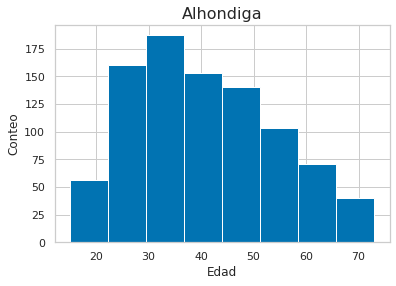

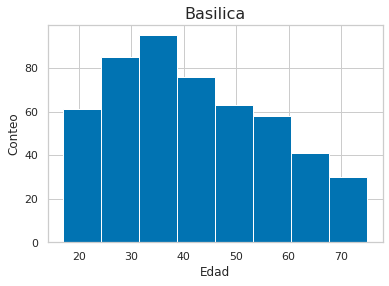

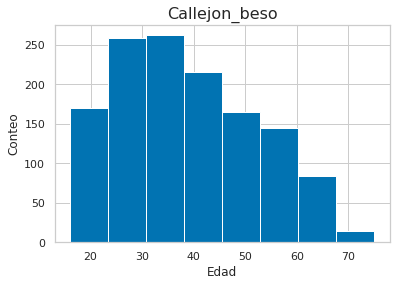

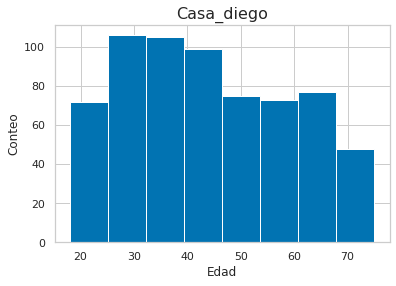

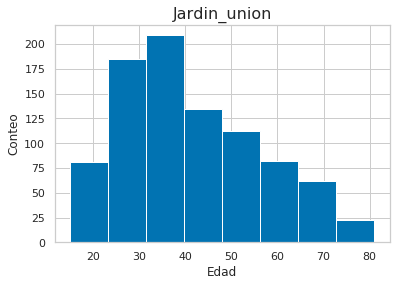

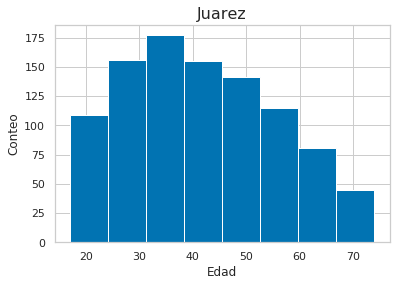

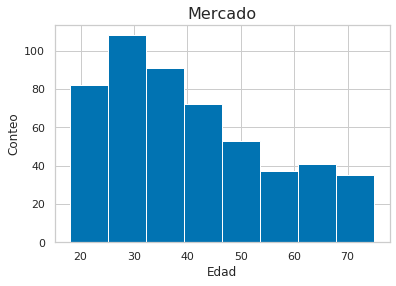

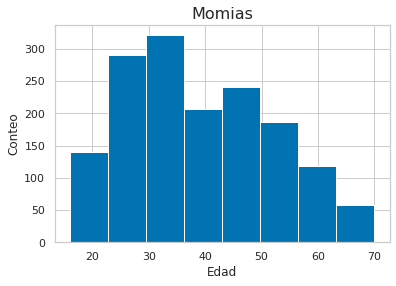

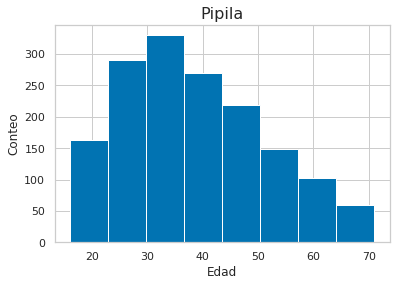

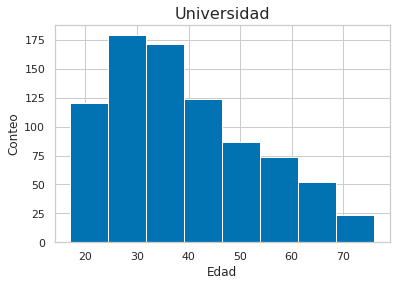

In [29]:
grouped = data.groupby('Negocio')

for group in grouped:
    fig, ax = plt.subplots(1, 1)
    ax.set_title(group[0])
    ax.set_xlabel('Edad')
    ax.set_ylabel('Conteo')
    _ = ax.hist(group[1].Edad, bins=8)
    plt.show()

#### d. Histograma de tipo de visitantes (nacional o internacional) por lugar

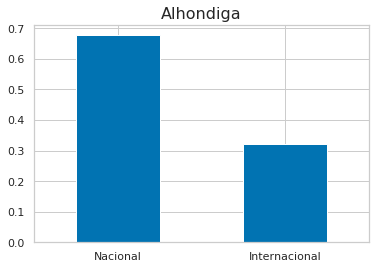

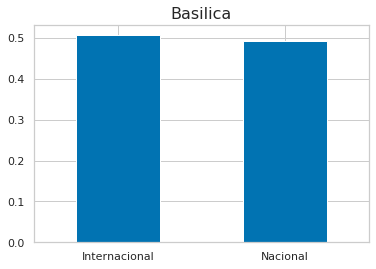

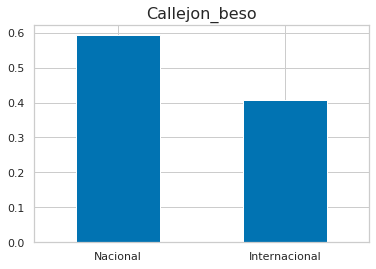

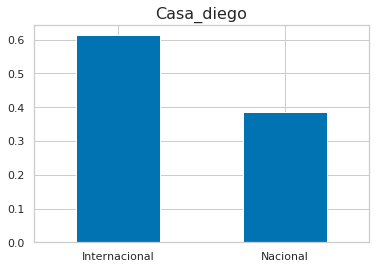

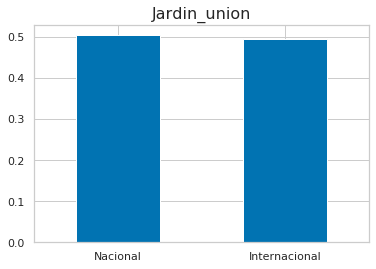

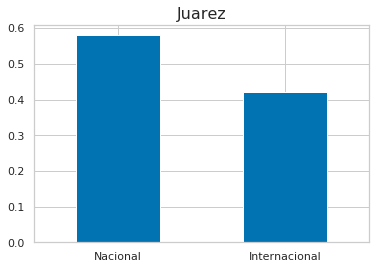

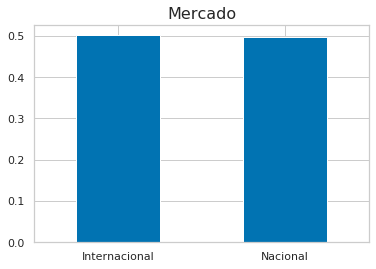

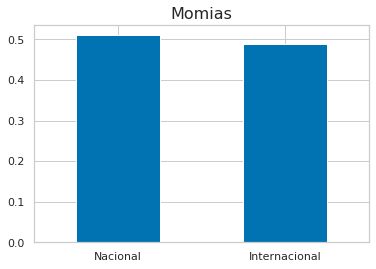

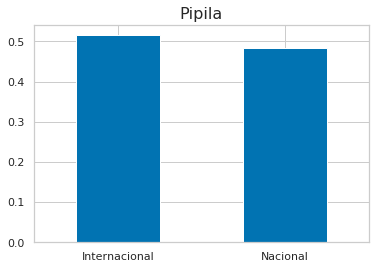

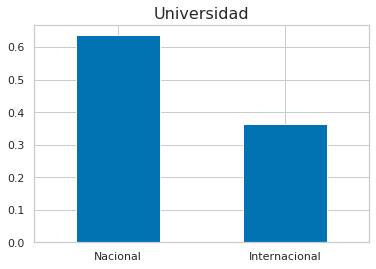

In [27]:
grouped = data.groupby('Negocio')

for group in grouped:
    ax = group[1].loc[:,'Tipo_turista'].value_counts(normalize=True).plot(kind='bar', title = group[0])
    ax.tick_params(labelrotation=0)
    plt.show()

## 2. Feature selection y nube de palabras

In [119]:
opinions = []
locations = []
location_names = []
grouped = data.groupby('Negocio')

for group in grouped:
    group_opinions = [op.strip('\"') for op in group[1].loc[:,'Opinión']]
    group_location = [op.strip('\"') for op in group[1].loc[:,'Negocio']]
    opinions.append(group_opinions)
    locations.append(group_location)
    location_names.append(group[0])

all_opinions = [item for group_opinions in opinions for item in group_opinions]
all_locations = [item for group_location in locations for item in group_location]

In [114]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2

k = 50
top_words = []

for group_opinions in opinions:

    vectorizer = CountVectorizer()
    tokens_matrix = vectorizer.fit_transform(group_opinions)

    features_chi2 = chi2(tokens_matrix, group_opinions)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(vectorizer.get_feature_names())[indices]

    group_top_words = [v for v in feature_names if len(v.split(' ')) == 1][:k]
    top_words.append(group_top_words)

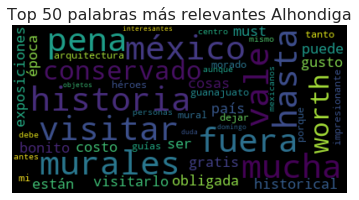

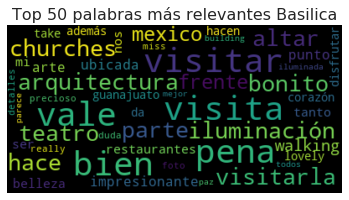

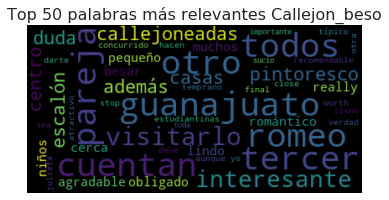

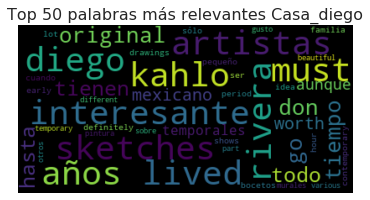

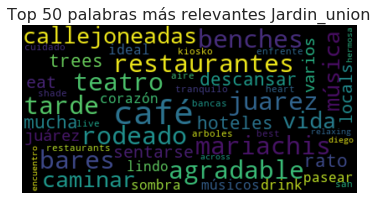

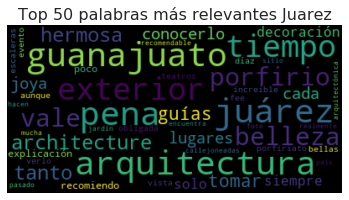

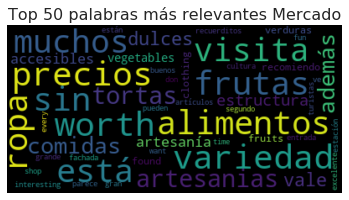

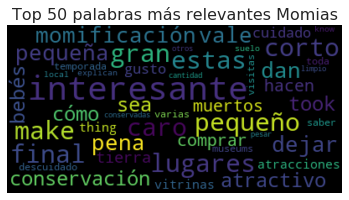

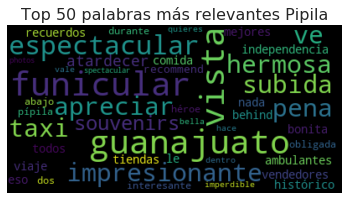

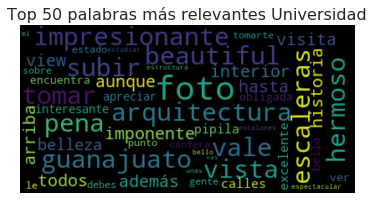

In [122]:
from wordcloud import WordCloud

for group_top_words, name in zip(top_words, location_names):
    text = " ".join(group_top_words)

    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Top "+str(k)+" palabras más relevantes " + name)
    plt.show()

## 3. Tópicos LSA

In [88]:
def get_lsa_words(text, n_topics, n_words):
    
    cv = CountVectorizer(stop_words=stopwords.words('spanish')+stopwords.words('english'))
    tf_matrix = cv.fit_transform(text)

    lsa_model = TruncatedSVD(n_components=n_topics)
    lsa_topic_matrix = lsa_model.fit_transform(tf_matrix)

    topics_id = lsa_topic_matrix.argmax(axis=1).tolist()
    terms = np.array(cv.get_feature_names())
    top_word_indices = []

    for topic in range(n_topics):
        words_frec_sum = np.zeros(tf_matrix.shape[1])

        for i in range(len(topics_id)):
            if topics_id[i] == topic:
                words_frec_sum += tf_matrix[i].toarray()[0]

        top_n_word_indices = np.flip(np.argsort(words_frec_sum)[-n_words:],0)
        top_word_indices.append(top_n_word_indices)
        
    top_words = [terms[indx] for indx in top_word_indices]
    
    return top_words

In [142]:
def print_format(location_name, words_topics, value):
    
    print("\n LSA: "+location_name+" - "+value+"\n")
    for i, words in enumerate(words_topics):
        print("  Tópico {}: \n    {}\n".format(i+1, ", ".join(words)))

In [188]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords

grouped = data.groupby('Negocio')
n_topics = 3
n_words = 10

for group in grouped:

    print("-"*30)
    
    # LSA Género masculino
    location_name = group[0]
    group_rows = group[1].query('Género == "Masculino"')
    group_opinions = [op.strip('\"') for op in group_rows.loc[:,'Opinión']]
    words_topics = get_lsa_words(group_opinions, n_topics, n_words)
    print_format(location_name, words_topics, "Hombres")
    
    # LSA Género femenino
    location_name = group[0]
    group_rows = group[1].query('Género == "Femenino"')
    group_opinions = [op.strip('\"') for op in group_rows.loc[:,'Opinión']]
    words_topics = get_lsa_words(group_opinions, n_topics, n_words)
    print_format(location_name, words_topics, "Mujeres")
    
    # LSA Turistas nacionales
    location_name = group[0]
    group_rows = group[1].query('Tipo_turista == "Nacional"')
    group_opinions = [op.strip('\"') for op in group_rows.loc[:,'Opinión']]
    words_topics = get_lsa_words(group_opinions, n_topics, n_words)
    print_format(location_name, words_topics, "Turistas nacionales")
    
    # LSA Turistas internacionales
    location_name = group[0]
    group_rows = group[1].query('Tipo_turista == "Internacional"')
    group_opinions = [op.strip('\"') for op in group_rows.loc[:,'Opinión']]
    words_topics = get_lsa_words(group_opinions, n_topics, n_words)
    print_format(location_name, words_topics, "Turistas internacionales")
    
     # LSA Jovenes
    location_name = group[0]
    group_rows = group[1].query('20 <= Edad <= 35')
    group_opinions = [op.strip('\"') for op in group_rows.loc[:,'Opinión']]
    words_topics = get_lsa_words(group_opinions, n_topics, n_words)
    print_format(location_name, words_topics, "Jovenes")
    
    # LSA Mayores
    location_name = group[0]
    group_rows = group[1].query('Edad >= 50')
    group_opinions = [op.strip('\"') for op in group_rows.loc[:,'Opinión']]
    words_topics = get_lsa_words(group_opinions, n_topics, n_words)
    print_format(location_name, words_topics, "Mayores")

------------------------------

 LSA: Alhondiga - Hombres

  Tópico 1: 
    historia, lugar, museo, independencia, méxico, guanajuato, si, visita, visitar, bien

  Tópico 2: 
    history, independence, museum, mexican, building, spanish, place, mexico, murals, one

  Tópico 3: 
    hidalgo, edificio, miguel, allende, guanajuato, ignacio, independencia, ejército, costilla, independence


 LSA: Alhondiga - Mujeres

  Tópico 1: 
    historia, lugar, museo, guanajuato, méxico, si, independencia, bien, visitar, alhóndiga

  Tópico 2: 
    history, museum, building, spanish, mexican, mexico, independence, well, guanajuato, place

  Tópico 3: 
    museo, salas, independencia, murales, edificio, puedes, mejor, entrada, exposición, cada


 LSA: Alhondiga - Turistas nacionales

  Tópico 1: 
    historia, lugar, museo, independencia, méxico, guanajuato, si, visitar, visita, bien

  Tópico 2: 
    lugar, ciudad, gratis, visitar, información, entrada, ir, puedo, histórico, importante

  Tópico 3: 



 LSA: Jardin_union - Turistas internacionales

  Tópico 1: 
    restaurants, people, place, jardin, music, one, around, great, guanajuato, trees

  Tópico 2: 
    city, buses, good, mexico, class, food, pesos, try, one, centro

  Tópico 3: 
    restaurantes, lugar, ciudad, plaza, guanajuato, teatro, noche, centro, gente, jardín


 LSA: Jardin_union - Jovenes

  Tópico 1: 
    lugar, restaurantes, guanajuato, teatro, jardín, jardin, ciudad, restaurants, gente, centro

  Tópico 2: 
    around, place, garden, one, nice, also, quite, city, people, good

  Tópico 3: 
    único, específicamente, esquina, esposo, esplendor, espero, esperaría, esperarlo, esperando, espectáculos


 LSA: Jardin_union - Mayores

  Tópico 1: 
    place, restaurants, people, jardin, great, one, trees, music, around, plaza

  Tópico 2: 
    tour, one, around, manuel, us, guide, city, walking, also, churches

  Tópico 3: 
    lugar, restaurantes, guanajuato, ciudad, teatro, jardín, música, centro, noche, plaza

----


 LSA: Pipila - Jovenes

  Tópico 1: 
    vista, ciudad, guanajuato, monumento, lugar, subir, puedes, pípila, si, funicular

  Tópico 2: 
    view, city, monument, funicular, take, guanajuato, walk, top, pipila, great

  Tópico 3: 
    autobús, ciudad, pípila, guanajuato, puede, camino, noche, bien, centro, si


 LSA: Pipila - Mayores

  Tópico 1: 
    view, city, monument, funicular, take, pipila, guanajuato, see, top, get

  Tópico 2: 
    ciudad, vista, guanajuato, monumento, lugar, pípila, subir, ver, puedes, funicular

  Tópico 3: 
    único, espacio, escultura, escudo, escuché, escucha, esclavitud, escenas, escenario, escena

------------------------------

 LSA: Universidad - Hombres

  Tópico 1: 
    guanajuato, universidad, ciudad, lugar, edificio, arquitectura, vista, escaleras, si, visitar

  Tópico 2: 
    building, university, guanajuato, city, stairs, steps, beautiful, great, nice, place

  Tópico 3: 
    útil, español, espacios, espacio, esfuerzo, esencia, escultura, esc

## 4. Nubes palabras para opiniones negativas

In [152]:
def sortFreqDict(freqdict):
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

In [150]:
opinions = []
locations = []
location_names = []
grouped = data.query('Sentimiento == "Negativo"').groupby('Negocio')

for group in grouped:
    group_opinions = [op.strip('\"') for op in group[1].loc[:,'Opinión']]
    group_location = [op.strip('\"') for op in group[1].loc[:,'Negocio']]
    opinions.append(group_opinions)
    locations.append(group_location)
    location_names.append(group[0])

all_opinions = [item for group_opinions in opinions for item in group_opinions]
all_locations = [item for group_location in locations for item in group_location]

In [153]:
corpus_palabras = []
for doc in all_opinions:
    corpus_palabras += doc.split()
    
fdist = nltk.FreqDist(corpus_palabras)
V = sortFreqDict(fdist)

dict_indices = dict()
index2word = dict()
cont = 0
for weight, word in V:
    dict_indices[word] = cont
    index2word[cont] = word
    cont += 1

In [185]:
from collections import defaultdict

n_ip = defaultdict(int)

for word in dict_indices.keys():
    for tweet, category in zip(all_opinions, all_locations):
        if word in tweet:
            n_ip[(word, category)] += 1
            
chi = []
location_vals = list(set(all_locations))
n_p = {v :all_locations.count(v) for v in location_vals}
nt = len(all_locations)
for word, index in zip(dict_indices.keys(), dict_indices.values()):
    chi_w = 0
    ni_elems = [n_ip[(word, v)] for v in location_vals]
    ni = np.sum(ni_elems)
    for category in location_vals:
        term1 = nt*n_ip[(word, category)]
        term2 = n_p[category]*ni
        den = n_p[category]*ni*(nt-n_p[category])*(nt-ni)
        if den == 0:
            chi_wc = 0
        else:
            chi_wc = (nt*(term1-term2)**2)/den

        chi.append((category, (chi_wc, index)))

In [186]:
k = 50
chi_list = [[chi_wc for cat, chi_wc in chi if cat == v] for v in location_vals]
chi_words = [[index2word[i] for chi_val, i in sorted(l, reverse = True)[:k]] for l in chi_list]

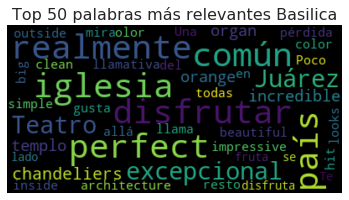

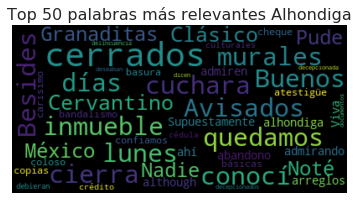

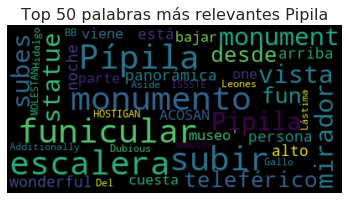

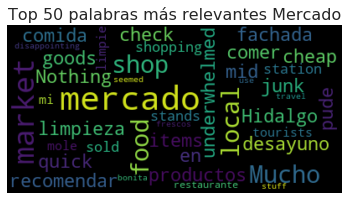

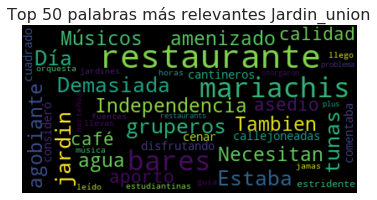

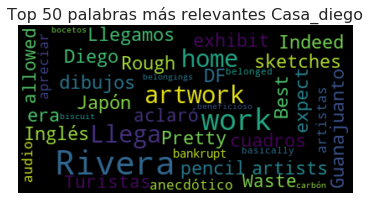

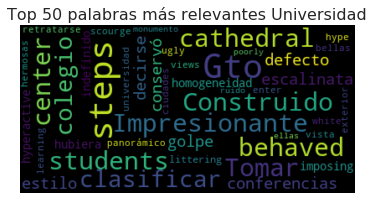

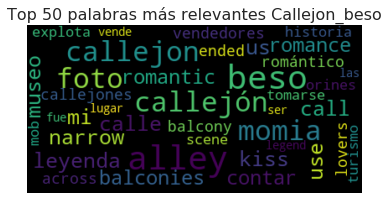

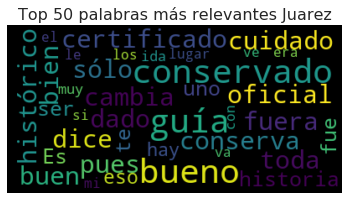

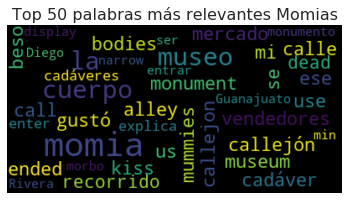

In [187]:
from wordcloud import WordCloud

for group_top_words, name in zip(chi_words, location_vals):
    text = " ".join(group_top_words)

    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Top "+str(k)+" palabras más relevantes " + name)
    plt.show()

## 5. Representaciones BOW

In [219]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from scipy.sparse import hstack
from nltk.corpus import stopwords

grouped = data.groupby('Negocio')
location_names = []
top_words = []
k = 50

for group in grouped:
    
    location_name = group[0]
    location_names.append(location_name)
    group_opinions = [op.strip('\"') for op in group[1].loc[:,'Opinión']]
    
    vc_term = TfidfVectorizer(max_features = 1000,  analyzer = 'word', ngram_range = (1,1))
    BOW_term = vc_term.fit_transform(group_opinions)
    
    vc_bigram = TfidfVectorizer(max_features = 2000,  analyzer = 'word', ngram_range = (2,2))
    BOW_bigram = vc_bigram.fit_transform(group_opinions)
    
    vc_trigram = TfidfVectorizer(max_features = 1000,  analyzer = 'word', ngram_range = (3,3))
    BOW_trigram = vc_trigram.fit_transform(group_opinions)
    
    BOW_union = hstack([BOW_term,BOW_bigram,BOW_trigram])
    
    features_chi2 = chi2(BOW_union, group_opinions)
    indices = np.argsort(features_chi2[0])[:k]
    
    term_indices = [i for i in indices if i < 1000]
    bigram_indices = [i - 1000 for i in indices if i < 3000 and i >= 1000]
    trigram_indices = [i - 3000 for i in indices if i >= 3000]
    
    term_names = np.array(vc_term.get_feature_names())[term_indices]
    bigram_names = np.array(vc_bigram.get_feature_names())[bigram_indices]
    trigram_names = np.array(vc_trigram.get_feature_names())[trigram_indices]
    
    group_top_words = list(term_names)+list(bigram_names)+list(trigram_names)
    top_words.append(group_top_words)

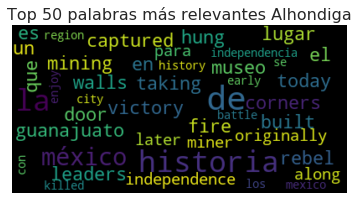

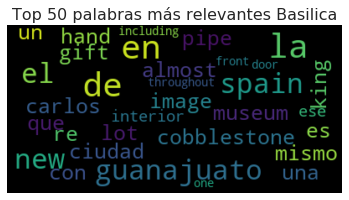

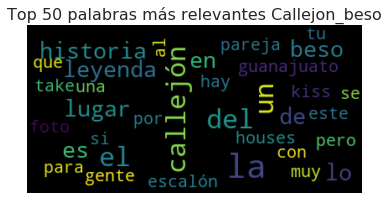

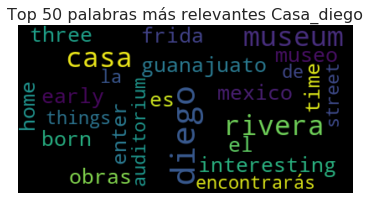

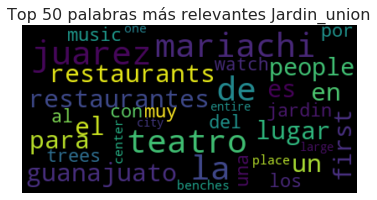

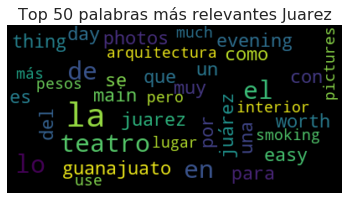

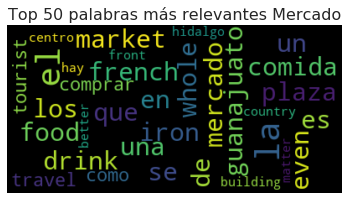

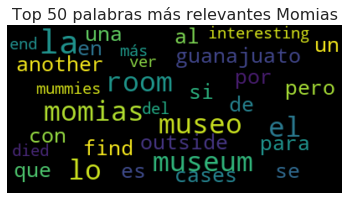

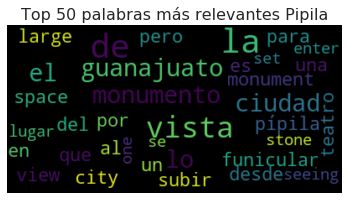

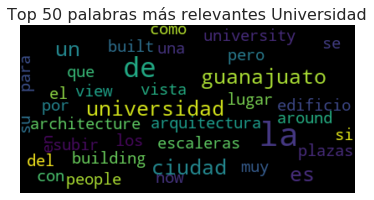

In [220]:
from wordcloud import WordCloud

for group_top_words, name in zip(top_words, location_names):
    
    if len(group_top_words) > 0:
    
        text = " ".join(group_top_words)

        wordcloud = WordCloud(max_font_size=40).generate(text)
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title("Top "+str(k)+" palabras más relevantes " + name)
        plt.show()

## 6. Ocurrencia temporal palabras con mayor ganancia de información

Sitio: Alhondiga


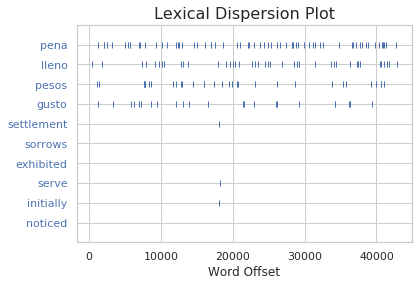

Sitio: Basilica


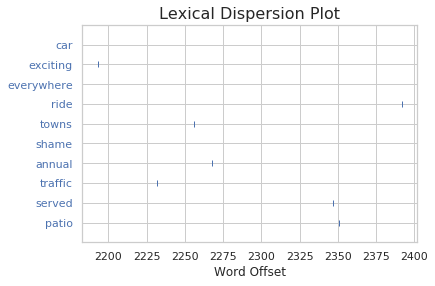

Sitio: Callejon_beso


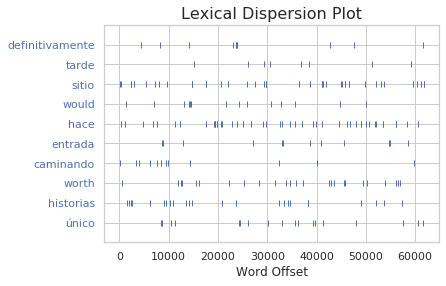

Sitio: Casa_diego


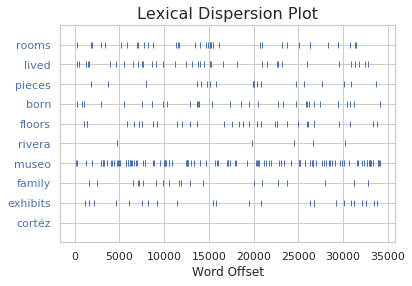

Sitio: Jardin_union


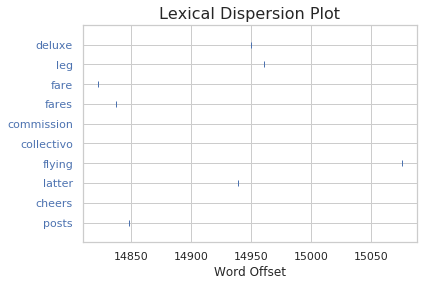

Sitio: Juarez


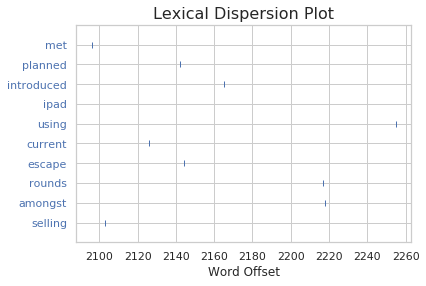

Sitio: Mercado


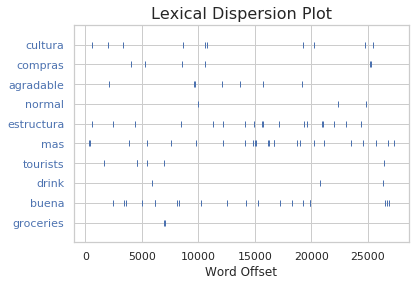

Sitio: Momias


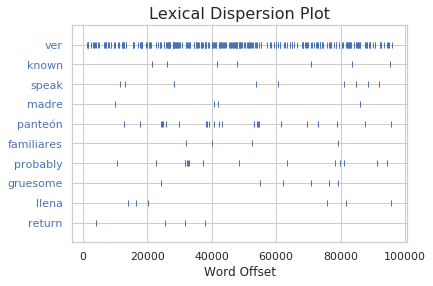

Sitio: Pipila


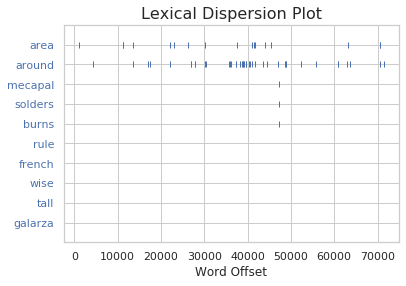

Sitio: Universidad


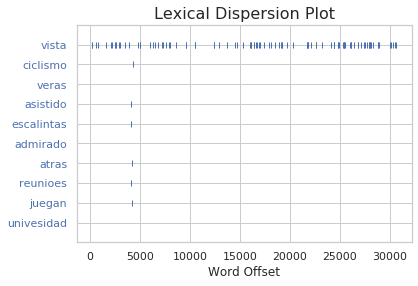

In [334]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
from nltk.corpus import stopwords
pd.options.mode.chained_assignment = None

grouped = data.groupby('Negocio')
location_names = []
top_words = []
k = 10

for group in grouped:
    
    location_name = group[0]
    df_group = group[1]
    location_names.append(location_name)

    df_group_ = df_group.astype({'Fecha': 'datetime64[ns]'})
    df_group = df_group.sort_values(by='Fecha', ascending=True)
    group_opinions = [op.strip('\"') for op in df_group.loc[:,'Opinión']]
    sentiments = list(df_group.loc[:,'Sentimiento'])
    
    vc_term = TfidfVectorizer(analyzer = 'word', ngram_range = (1,1), stop_words=stopwords.words('spanish')+stopwords.words('english'))
    BOW_term = vc_term.fit_transform(group_opinions)
  
    features_chi2 = chi2(BOW_term, sentiments)
    indices = np.argsort(features_chi2[0])
    term_names = np.array(vc_term.get_feature_names())[indices][:k]
    
    tokens = [w for op in group_opinions for w in op.split()]
    doc_text = nltk.Text(tokens)
    print("Sitio: "+location_name)
    doc_text.dispersion_plot(list(term_names))

## 7. Análisis temporal para opiniones positivas, neutras y negativas para cada sitio